In [1]:
from fastai2.text.all import *

## Create databunch form LM

In [2]:
BPTT=10
BS=64

EN_FILE = Path('data/en-clean.txt')
EN_TEXT = EN_FILE.read()[1:].replace('\n', '').replace('  ', ' ')

In [3]:
len(EN_TEXT)

1039052

In [4]:
toks = tokenize1(EN_TEXT)

In [5]:
toks[:10]

(#10) ['xxbos','the','project','gutenberg','ebook','of','peter','pan',',','by']

In [6]:
vocab = make_vocab(Counter(toks), min_freq=3, max_vocab=4000)

len(vocab)

4008

In [7]:
vocab[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 '.',
 'the',
 'and',
 'to',
 'a']

In [8]:
# arbitrary way of splitting text into 'examples', would probably be better to split by chapters
# or something along these lines but shouldn't make much of a difference
txts = np.array_split(EN_TEXT.split(), 100)

In [9]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True)), splitter=RandomSplitter(seed=42))

In [10]:
dbunch_lm = dblock.databunch(txts, seq_len=BPTT, bs=BS) 

In [11]:
dbunch_lm.one_batch()[0].shape

torch.Size([64, 10])

## Train LM

In [12]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    AWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

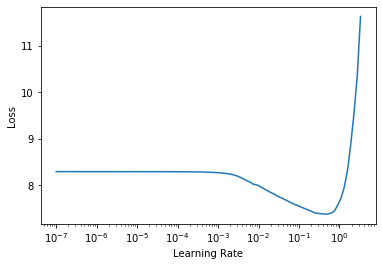

In [13]:
learn.lr_find()

In [14]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.941036,5.653147,0.097439,285.187469,00:11
1,5.535548,5.302301,0.138911,200.798294,00:11
2,5.280907,5.062784,0.161350,158.029816,00:11
3,5.074124,4.859920,0.194987,129.013885,00:11
4,4.882607,4.752127,0.205382,115.830414,00:10


In [15]:
learn.save('5epochs')

## Calculate loss given embeddings

In [30]:
learn = learn.load('5epochs')

In [22]:
preds, targs = learn.get_preds()

AttributeError: 'L' object has no attribute 'softmax'

For the time being I get an error as above - will implement manual loss calculation and replace this once it gets fixed ([github issue](https://github.com/fastai/fastai2/issues/35))

In [31]:
def loss():
    preds = []
    targs = []

    learn.model.eval()
    with torch.no_grad():
        for b in learn.dbunch.valid_dl:
            preds.append(learn.model(b[0])[0])
            targs.append(b[1])

    preds = torch.cat(preds, 1)
    targs = torch.cat(targs, 1)
    
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [32]:
emb_layer = learn.model[0].encoder

In [33]:
emb_layer.weight.shape

torch.Size([4008, 100])

In [34]:
loss()

(4.753739833831787, 0.20564089715480804)

In [35]:
emb_layer_weights = emb_layer.weight.clone()

In [36]:
emb_layer.weight[:15].zero_();

In [37]:
loss()

(5.313080310821533, 0.1253531128168106)

In [38]:
emb_layer.weight = nn.Parameter(emb_layer_weights)

In [39]:
loss()

(4.753595352172852, 0.20559674501419067)

## Permute embeddings

In [64]:
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) )
        self.p = nn.Parameter( torch.eye(self.num_embeddings) )
        self.p.requires_grad = False
        
        self.reset_parameters()
        
    def forward(self, words):
        return F.embedding(words, self.p @ self.weight)
    
    def reset_parameters(self):
        self.weight.data.normal_(0,1)
        self.p.data = torch.eye(self.num_embeddings)
    

In [65]:
class pAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder = PermuteEmbedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

In [66]:
import fastai2
fastai2.text.models.core._model_meta[pAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [67]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

In [68]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.930654,5.631249,0.098220,279.010376,00:11
1,5.544677,5.282267,0.146593,196.815567,00:11
2,5.242517,5.033709,0.164800,153.501236,00:11
3,5.064619,4.863100,0.191385,129.424744,00:11
4,4.917329,4.752985,0.202799,115.929817,00:11
